# Train a model on the deep-snow dataset

In [1]:
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import pickle
import random

import deep_snow.models
import deep_snow.dataset

## Prepare dataloader

In [2]:
# get paths to data
train_data_dir = '/mnt/Backups/gbrench/repos/deep-snow/data/subsets_v4/train'
train_path_list = glob(f'{train_data_dir}/ASO_50M_SD*.nc')

val_data_dir = '/mnt/Backups/gbrench/repos/deep-snow/data/subsets_v4/val'
val_path_list = glob(f'{val_data_dir}/ASO_50M_SD*.nc')

In [3]:
# # to test code with a small sample of the data
# import random
# n_imgs = 16

# train_path_list = random.sample(train_path_list, n_imgs )
# val_path_list = random.sample(val_path_list, n_imgs)

In [4]:
# define data to be returned by dataloader
selected_channels = [
    # ASO products
    'aso_sd', # ASO lidar snow depth (target dataset)
    'aso_gap_map', # gaps in ASO data
    
    # Sentinel-1 products
    'snowon_vv', # snow on Sentinel-1 VV polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowon_vh', # snow on Sentinel-1 VH polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowoff_vv', # snow off Sentinel-1 VV polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowoff_vh', # snow off Sentinel-1 VH polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowon_vv_mean', # snow on Sentinel-1 VV polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowon_vh_mean', # snow on Sentinel-1 VH polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowoff_vv_mean', # snow off Sentinel-1 VV polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowoff_vh_mean', # snow off Sentinel-1 VH polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowon_cr', # cross ratio, snowon_vh - snowon_vv
    'snowoff_cr', # cross ratio, snowoff_vh - snowoff_vv
    'delta_cr', # change in cross ratio, snowon_cr - snowoff_cr
    'rtc_gap_map', # gaps in Sentinel-1 data
    'rtc_mean_gap_map', # gaps in Sentinel-1 mean data
    
    # Sentinel-2 products 
    'aerosol_optical_thickness', # snow on Sentinel-2 aerosol optical thickness band 
    'coastal_aerosol', # snow on Sentinel-2 coastal aerosol band
    'blue', # snow on Sentinel-2 blue band
    'green', # snow on Sentinel-2 green band
    'red', # snow on Sentinel-2 red band
    'red_edge1', # snow on Sentinel-2 red edge 1 band
    'red_edge2', # snow on Sentinel-2 red edge 2 band
    'red_edge3', # snow on Sentinel-2 red edge 3 band
    'nir', # snow on Sentinel-2 near infrared band
    'water_vapor', # snow on Sentinel-2 water vapor
    'swir1', # snow on Sentinel-2 shortwave infrared band 1
    'swir2', # snow on Sentinel-2 shortwave infrared band 2
    'scene_class_map', # snow on Sentinel-2 scene classification product
    'water_vapor_product', # snow on Sentinel-2 water vapor product
    'ndvi', # Normalized Difference Vegetation Index from Sentinel-2
    'ndsi', # Normalized Difference Snow Index from Sentinel-2
    'ndwi', # Normalized Difference Water Index from Sentinel-2
    's2_gap_map', # gaps in Sentinel-2 data

    # snodas datset
    'snodas_sd', # snow depth

    # PROBA-V global land cover dataset (Buchhorn et al., 2020)
    'fcf', # fractional forest cover
    
    # COP30 digital elevation model      
    'elevation',
    'slope',
    'aspect',
    'curvature',
    'tpi',
    'tri',

    # latitude and longitude
    'latitude',
    'longitude',

    # day of water year
    'dowy'
                    ]

# prepare training and validation dataloaders
train_data = deep_snow.dataset.Dataset(train_path_list, selected_channels, norm=True, cache_data=True)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_data = deep_snow.dataset.Dataset(val_path_list, selected_channels, norm=True, augment=False, cache_data=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=16, shuffle=True)

In [5]:
# define input channels for model
input_channels = [
    'snowon_vv',
    'delta_cr',
    'green',
    'swir2',
    'ndsi',
    'ndwi',
    'snodas_sd',
    'elevation',
    'latitude',
    'longitude']

## Train model

In [6]:
# import model
# model = deep_snow.models.SimpleCNN(n_input_channels=len(input_channels))
# model = deep_snow.models.UNet(n_input_channels=len(input_channels))
# model = deep_snow.models.ResUNet(n_input_channels=len(input_channels))
# model = deep_snow.models.ResDepth(n_input_channels=len(input_channels))
# model = deep_snow.models.VisionTransformer(n_input_channels=len(input_channels))

model = deep_snow.models.ResDepth(n_input_channels=len(input_channels), depth=5)
model.to('cuda');  # Run on GPU

# name your model
model_name = 'quinn_ResDepth_v11'

In [7]:
# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
loss_fn = nn.MSELoss()
epochs = 500
min_val_loss = 1

train_loss = []
val_loss = []

# training and validation loop
for epoch in range(epochs):
    print(f'\nStarting epoch {epoch+1}')
    train_epoch_loss = []
    val_epoch_loss = []

    # Loop through training data with tqdm progress bar
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch", ncols=130)
    for data_tuple in train_pbar:
        model.train()
        optimizer.zero_grad()

        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}
        
        # prepare inputs by concatenating along channel dimension
        inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')

        # generate prediction
        pred_sd = model(inputs)

        # Limit prediction to areas with valid data
        pred_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, pred_sd, torch.zeros_like(pred_sd).to('cuda'))
        aso_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda')== 0, data_dict['aso_sd'].to('cuda'), torch.zeros_like(pred_sd).to('cuda'))

        # Calculate loss
        train_batch_loss = loss_fn(pred_sd, aso_sd.to('cuda'))
        train_epoch_loss.append(train_batch_loss.item())

        # Update tqdm progress bar with batch loss
        train_pbar.set_postfix({'batch loss': train_batch_loss.item(), 'mean epoch loss': np.mean(train_epoch_loss)})

        train_batch_loss.backward()  # Propagate the gradients in backward pass
        optimizer.step()

    train_loss.append(np.mean(train_epoch_loss))
    print(f'Training loss: {np.mean(train_epoch_loss)}')
    scheduler.step(np.mean(train_epoch_loss))

    # Run model on validation data with tqdm progress bar
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch", ncols=130)
    for data_tuple in val_pbar:
        with torch.no_grad():
            model.eval()
            
            # read data into dictionary
            data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}
            # prepare inputs by concatenating along channel dimension
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
    
            # generate prediction
            pred_sd = model(inputs)
    
            # Limit prediction to areas with valid data
            pred_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, pred_sd, torch.zeros_like(pred_sd).to('cuda'))
            aso_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, data_dict['aso_sd'].to('cuda'), torch.zeros_like(pred_sd).to('cuda'))
    
            # Calculate loss
            val_batch_loss = loss_fn(pred_sd, aso_sd.to('cuda'))
            val_epoch_loss.append(val_batch_loss.item())

            # Update tqdm progress bar with batch loss
            val_pbar.set_postfix({'batch loss': val_batch_loss.item(), 'mean epoch loss': np.mean(val_epoch_loss)})

    if np.mean(val_epoch_loss) < min_val_loss:
        if epoch > 30:
            min_val_loss = np.mean(val_epoch_loss)
            torch.save(model.state_dict(), f'../../../weights/{model_name}_{epoch}epochs')
                    
    # # calculate loss over previous 10 epochs for early stopping later
    # if epoch > 20:
    #     past_loss = np.mean(val_loss[-20:-10])

    val_loss.append(np.mean(val_epoch_loss))
    print(f'Validation loss: {np.mean(val_epoch_loss)}')
    
    # save loss 
    with open(f'../../../loss/{model_name}_val_loss.pkl', 'wb') as f:
        pickle.dump(val_loss, f)
        
    with open(f'../../../loss/{model_name}_train_loss.pkl', 'wb') as f:
        pickle.dump(train_loss, f)

    # # implement early stopping
    # if epoch > 20:
    #     current_loss = np.mean(val_loss[-10:-1])
    #     if current_loss > past_loss:
    #         counter +=1
    #         if counter >= 10:
    #             print('early stopping triggered')
    #             # save model
    #             torch.save(model.state_dict(), f'../../weights/{model_name}_{epoch}epochs')
    #             break
    #     else:
    #         counter = 0


Starting epoch 1


Epoch 1/500: 100%|█████████████████████████████| 774/774 [1:00:36<00:00,  4.70s/batch, batch loss=0.00157, mean epoch loss=0.0022]


Training loss: 0.0022008610796514245


Epoch 1/500: 100%|██████████████████████████████| 135/135 [11:33<00:00,  5.13s/batch, batch loss=0.00131, mean epoch loss=0.00147]


Validation loss: 0.0014731401185229145

Starting epoch 2


Epoch 19/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.37batch/s, batch loss=0.00121, mean epoch loss=0.00141]


Training loss: 0.0014140145684216707


Epoch 19/500: 100%|█████████████████████████████| 135/135 [00:03<00:00, 35.62batch/s, batch loss=0.00093, mean epoch loss=0.00109]


Validation loss: 0.0010930291368384604

Starting epoch 20


Epoch 20/500: 100%|██████████████████████████████| 774/774 [02:25<00:00,  5.32batch/s, batch loss=0.0034, mean epoch loss=0.00141]


Training loss: 0.0014081314030409916


Epoch 20/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.55batch/s, batch loss=0.000772, mean epoch loss=0.00103]


Validation loss: 0.0010288685850725785

Starting epoch 21


Epoch 21/500: 100%|██████████████████████████████| 774/774 [02:24<00:00,  5.37batch/s, batch loss=0.0014, mean epoch loss=0.00139]


Training loss: 0.0013875870197253045


Epoch 21/500: 100%|██████████████████████████████| 135/135 [00:03<00:00, 35.40batch/s, batch loss=0.0013, mean epoch loss=0.00103]


Validation loss: 0.0010272074769966787

Starting epoch 22


Epoch 22/500: 100%|████████████████████████████| 774/774 [02:23<00:00,  5.39batch/s, batch loss=0.000518, mean epoch loss=0.00138]


Training loss: 0.0013757628026296257


Epoch 22/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.40batch/s, batch loss=0.00188, mean epoch loss=0.000983]


Validation loss: 0.00098266893172102

Starting epoch 23


Epoch 23/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.35batch/s, batch loss=0.00171, mean epoch loss=0.00137]


Training loss: 0.0013665458751789437


Epoch 23/500: 100%|█████████████████████████████| 135/135 [00:03<00:00, 35.74batch/s, batch loss=0.000513, mean epoch loss=0.0011]


Validation loss: 0.0011033220327118652

Starting epoch 24


Epoch 24/500: 100%|█████████████████████████████| 774/774 [02:25<00:00,  5.33batch/s, batch loss=0.00248, mean epoch loss=0.00136]


Training loss: 0.0013609077330291853


Epoch 24/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.46batch/s, batch loss=0.000657, mean epoch loss=0.000998]


Validation loss: 0.000998088514272779

Starting epoch 25


Epoch 25/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.37batch/s, batch loss=0.00142, mean epoch loss=0.00135]


Training loss: 0.0013510699884808689


Epoch 25/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.96batch/s, batch loss=0.000844, mean epoch loss=0.000987]


Validation loss: 0.0009870414858192413

Starting epoch 26


Epoch 26/500: 100%|█████████████████████████████| 774/774 [02:25<00:00,  5.34batch/s, batch loss=0.00118, mean epoch loss=0.00135]


Training loss: 0.001354543394000764


Epoch 26/500: 100%|██████████████████████████████| 135/135 [00:03<00:00, 35.74batch/s, batch loss=0.00128, mean epoch loss=0.0011]


Validation loss: 0.0011029490763407753

Starting epoch 27


Epoch 27/500: 100%|████████████████████████████| 774/774 [02:24<00:00,  5.36batch/s, batch loss=0.000908, mean epoch loss=0.00133]


Training loss: 0.0013340935345869378


Epoch 27/500: 100%|██████████████████████████████| 135/135 [00:03<00:00, 35.82batch/s, batch loss=0.0023, mean epoch loss=0.00118]


Validation loss: 0.0011812037096307095

Starting epoch 28


Epoch 28/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.37batch/s, batch loss=0.00281, mean epoch loss=0.00132]


Training loss: 0.0013197785602226428


Epoch 28/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 36.01batch/s, batch loss=0.000658, mean epoch loss=0.000966]


Validation loss: 0.0009662760125205818

Starting epoch 29


Epoch 29/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.35batch/s, batch loss=0.00181, mean epoch loss=0.00131]


Training loss: 0.001313876501793368


Epoch 29/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.63batch/s, batch loss=0.000282, mean epoch loss=0.000962]


Validation loss: 0.0009618104859125903

Starting epoch 30


Epoch 30/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.36batch/s, batch loss=0.00336, mean epoch loss=0.00133]


Training loss: 0.0013315895484429206


Epoch 30/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.80batch/s, batch loss=0.000841, mean epoch loss=0.000959]


Validation loss: 0.0009589723249384271

Starting epoch 31


Epoch 31/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.35batch/s, batch loss=0.00256, mean epoch loss=0.00131]


Training loss: 0.0013054116581008922


Epoch 31/500: 100%|█████████████████████████████| 135/135 [00:03<00:00, 35.40batch/s, batch loss=0.00107, mean epoch loss=0.00106]


Validation loss: 0.0010577204905631436

Starting epoch 32


Epoch 32/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.34batch/s, batch loss=0.000519, mean epoch loss=0.0013]


Training loss: 0.0012991633024618681


Epoch 32/500: 100%|█████████████████████████████| 135/135 [00:03<00:00, 35.96batch/s, batch loss=0.00163, mean epoch loss=0.00103]


Validation loss: 0.001031302420004202

Starting epoch 33


Epoch 33/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.37batch/s, batch loss=0.00145, mean epoch loss=0.00128]


Training loss: 0.0012840279393789699


Epoch 33/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.77batch/s, batch loss=0.00223, mean epoch loss=0.000962]


Validation loss: 0.0009621758930195399

Starting epoch 34


Epoch 34/500: 100%|████████████████████████████| 774/774 [02:23<00:00,  5.39batch/s, batch loss=0.000191, mean epoch loss=0.00127]


Training loss: 0.0012707009124568092


Epoch 34/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.77batch/s, batch loss=0.000816, mean epoch loss=0.000964]


Validation loss: 0.0009637676677946863

Starting epoch 35


Epoch 35/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.34batch/s, batch loss=0.00229, mean epoch loss=0.00128]


Training loss: 0.0012753139356882503


Epoch 35/500: 100%|█████████████████████████████| 135/135 [00:03<00:00, 35.59batch/s, batch loss=0.00135, mean epoch loss=0.00106]


Validation loss: 0.0010622456914495195

Starting epoch 36


Epoch 36/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.36batch/s, batch loss=0.00129, mean epoch loss=0.00126]


Training loss: 0.0012586926354660646


Epoch 36/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.91batch/s, batch loss=0.000961, mean epoch loss=0.000993]


Validation loss: 0.0009928420002796447

Starting epoch 37


Epoch 37/500: 100%|█████████████████████████████| 774/774 [02:23<00:00,  5.40batch/s, batch loss=0.00151, mean epoch loss=0.00128]


Training loss: 0.001277225332395026


Epoch 37/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.90batch/s, batch loss=0.00182, mean epoch loss=0.000976]


Validation loss: 0.000976427725874129

Starting epoch 38


Epoch 38/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.35batch/s, batch loss=0.00118, mean epoch loss=0.00125]


Training loss: 0.001250609331320203


Epoch 38/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.75batch/s, batch loss=0.000734, mean epoch loss=0.000929]


Validation loss: 0.0009291870448376155

Starting epoch 39


Epoch 39/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.35batch/s, batch loss=0.00158, mean epoch loss=0.00125]


Training loss: 0.001249687747370442


Epoch 39/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.85batch/s, batch loss=0.00032, mean epoch loss=0.000958]


Validation loss: 0.0009582706126686255

Starting epoch 40


Epoch 40/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.35batch/s, batch loss=0.00101, mean epoch loss=0.00124]


Training loss: 0.0012424968666825997


Epoch 40/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.58batch/s, batch loss=0.00183, mean epoch loss=0.000981]


Validation loss: 0.0009808804561207243

Starting epoch 41


Epoch 41/500: 100%|████████████████████████████| 774/774 [02:25<00:00,  5.32batch/s, batch loss=0.000253, mean epoch loss=0.00124]


Training loss: 0.0012368701704226083


Epoch 41/500: 100%|█████████████████████████████| 135/135 [00:03<00:00, 35.88batch/s, batch loss=7.23e-5, mean epoch loss=0.00101]


Validation loss: 0.0010098694595163343

Starting epoch 42


Epoch 42/500: 100%|█████████████████████████████| 774/774 [02:23<00:00,  5.38batch/s, batch loss=0.00168, mean epoch loss=0.00122]


Training loss: 0.001219181409500102


Epoch 42/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.69batch/s, batch loss=0.00159, mean epoch loss=0.000949]


Validation loss: 0.0009492596290160523

Starting epoch 43


Epoch 43/500: 100%|████████████████████████████| 774/774 [02:23<00:00,  5.38batch/s, batch loss=0.000572, mean epoch loss=0.00122]


Training loss: 0.0012155291280498337


Epoch 43/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.72batch/s, batch loss=0.000842, mean epoch loss=0.00093]


Validation loss: 0.0009301297127320948

Starting epoch 44


Epoch 44/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.35batch/s, batch loss=0.00107, mean epoch loss=0.00122]


Training loss: 0.0012193597476112413


Epoch 44/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.91batch/s, batch loss=0.000464, mean epoch loss=0.000926]


Validation loss: 0.0009262687095475418

Starting epoch 45


Epoch 45/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.36batch/s, batch loss=0.00171, mean epoch loss=0.00121]


Training loss: 0.0012125788289502814


Epoch 45/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.39batch/s, batch loss=0.00157, mean epoch loss=0.000931]


Validation loss: 0.0009314779065014725

Starting epoch 46


Epoch 46/500: 100%|█████████████████████████████| 774/774 [02:23<00:00,  5.38batch/s, batch loss=0.000708, mean epoch loss=0.0012]


Training loss: 0.0011957917038962853


Epoch 46/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.59batch/s, batch loss=0.00128, mean epoch loss=0.000987]


Validation loss: 0.000986633617517159

Starting epoch 47


Epoch 47/500: 100%|████████████████████████████| 774/774 [02:24<00:00,  5.35batch/s, batch loss=0.000726, mean epoch loss=0.00118]


Training loss: 0.0011828307492308197


Epoch 47/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.71batch/s, batch loss=0.00105, mean epoch loss=0.000914]


Validation loss: 0.0009140448760094673

Starting epoch 48


Epoch 48/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.34batch/s, batch loss=0.00245, mean epoch loss=0.00121]


Training loss: 0.001208357840350189


Epoch 48/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.83batch/s, batch loss=0.00139, mean epoch loss=0.000933]


Validation loss: 0.0009332905432933734

Starting epoch 49


Epoch 49/500: 100%|████████████████████████████| 774/774 [02:23<00:00,  5.38batch/s, batch loss=0.000783, mean epoch loss=0.00118]


Training loss: 0.001182763506832848


Epoch 49/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.52batch/s, batch loss=0.00112, mean epoch loss=0.000911]


Validation loss: 0.000911312004986771

Starting epoch 50


Epoch 50/500: 100%|█████████████████████████████| 774/774 [02:25<00:00,  5.31batch/s, batch loss=0.00172, mean epoch loss=0.00117]


Training loss: 0.0011712796637157908


Epoch 50/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.86batch/s, batch loss=0.000763, mean epoch loss=0.000911]


Validation loss: 0.000911068659236965

Starting epoch 51


Epoch 51/500: 100%|████████████████████████████| 774/774 [02:24<00:00,  5.34batch/s, batch loss=0.000746, mean epoch loss=0.00117]


Training loss: 0.0011737459120057879


Epoch 51/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.44batch/s, batch loss=0.000674, mean epoch loss=0.000949]


Validation loss: 0.0009492221652719848

Starting epoch 52


Epoch 52/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.37batch/s, batch loss=0.00118, mean epoch loss=0.00117]


Training loss: 0.0011739542936457703


Epoch 52/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.74batch/s, batch loss=0.000815, mean epoch loss=0.00101]


Validation loss: 0.0010078900818135245

Starting epoch 53


Epoch 53/500: 100%|████████████████████████████| 774/774 [02:25<00:00,  5.34batch/s, batch loss=0.000411, mean epoch loss=0.00116]


Training loss: 0.0011636783694968743


Epoch 53/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.64batch/s, batch loss=0.000644, mean epoch loss=0.000931]


Validation loss: 0.0009307611064286903

Starting epoch 54


Epoch 54/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.35batch/s, batch loss=0.00252, mean epoch loss=0.00116]


Training loss: 0.0011571383919208975


Epoch 54/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 36.07batch/s, batch loss=0.000959, mean epoch loss=0.000915]


Validation loss: 0.0009151569049141405

Starting epoch 55


Epoch 55/500: 100%|█████████████████████████████| 774/774 [02:23<00:00,  5.39batch/s, batch loss=0.00191, mean epoch loss=0.00115]


Training loss: 0.001147506645652321


Epoch 55/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.43batch/s, batch loss=0.00206, mean epoch loss=0.000922]


Validation loss: 0.0009224650415826882

Starting epoch 56


Epoch 56/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.35batch/s, batch loss=0.00246, mean epoch loss=0.00114]


Training loss: 0.0011433947375225468


Epoch 56/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.73batch/s, batch loss=0.00132, mean epoch loss=0.000933]


Validation loss: 0.0009331662164725087

Starting epoch 57


Epoch 57/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.37batch/s, batch loss=0.00108, mean epoch loss=0.00114]


Training loss: 0.0011374894333299422


Epoch 57/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.67batch/s, batch loss=0.00143, mean epoch loss=0.000921]


Validation loss: 0.0009208171340072079

Starting epoch 58


Epoch 58/500: 100%|████████████████████████████| 774/774 [02:24<00:00,  5.35batch/s, batch loss=0.000483, mean epoch loss=0.00114]


Training loss: 0.0011426726692610057


Epoch 58/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.90batch/s, batch loss=0.000581, mean epoch loss=0.000894]


Validation loss: 0.0008939411608648866

Starting epoch 59


Epoch 59/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.35batch/s, batch loss=0.00118, mean epoch loss=0.00112]


Training loss: 0.0011242319468897045


Epoch 59/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.59batch/s, batch loss=0.00084, mean epoch loss=0.000946]


Validation loss: 0.0009464933957335436

Starting epoch 60


Epoch 60/500: 100%|████████████████████████████| 774/774 [02:24<00:00,  5.34batch/s, batch loss=0.000331, mean epoch loss=0.00114]


Training loss: 0.0011366976815960503


Epoch 60/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.81batch/s, batch loss=0.000831, mean epoch loss=0.000905]


Validation loss: 0.0009049922612137851

Starting epoch 61


Epoch 61/500: 100%|████████████████████████████| 774/774 [02:24<00:00,  5.36batch/s, batch loss=0.000903, mean epoch loss=0.00113]


Training loss: 0.0011267190336539154


Epoch 61/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.93batch/s, batch loss=0.000183, mean epoch loss=0.000943]


Validation loss: 0.0009433006322339039

Starting epoch 62


Epoch 62/500: 100%|█████████████████████████████| 774/774 [02:25<00:00,  5.33batch/s, batch loss=0.00157, mean epoch loss=0.00111]


Training loss: 0.0011085541694766771


Epoch 62/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.78batch/s, batch loss=0.00039, mean epoch loss=0.000906]


Validation loss: 0.0009063471796387737

Starting epoch 63


Epoch 63/500: 100%|██████████████████████████████| 774/774 [02:25<00:00,  5.34batch/s, batch loss=0.00256, mean epoch loss=0.0011]


Training loss: 0.0010984813379858096


Epoch 63/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.36batch/s, batch loss=0.00246, mean epoch loss=0.000944]


Validation loss: 0.0009437564465096565

Starting epoch 64


Epoch 64/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.34batch/s, batch loss=0.00108, mean epoch loss=0.00112]


Training loss: 0.001119914373580862


Epoch 64/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.44batch/s, batch loss=0.000755, mean epoch loss=0.00093]


Validation loss: 0.000930223297608016

Starting epoch 65


Epoch 65/500: 100%|███████████████████████████████| 774/774 [02:26<00:00,  5.30batch/s, batch loss=0.0011, mean epoch loss=0.0011]


Training loss: 0.0011040058884869248


Epoch 65/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.59batch/s, batch loss=0.000444, mean epoch loss=0.000916]


Validation loss: 0.0009162513947726607

Starting epoch 66


Epoch 66/500: 100%|████████████████████████████| 774/774 [02:23<00:00,  5.38batch/s, batch loss=0.000575, mean epoch loss=0.00111]


Training loss: 0.00110976900647046


Epoch 66/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.65batch/s, batch loss=0.000787, mean epoch loss=0.000885]


Validation loss: 0.0008852743519970251

Starting epoch 67


Epoch 67/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.35batch/s, batch loss=0.00153, mean epoch loss=0.00108]


Training loss: 0.0010772417631097744


Epoch 67/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.53batch/s, batch loss=0.000793, mean epoch loss=0.000911]


Validation loss: 0.0009111335949489364

Starting epoch 68


Epoch 68/500: 100%|████████████████████████████| 774/774 [02:25<00:00,  5.33batch/s, batch loss=0.000193, mean epoch loss=0.00109]


Training loss: 0.0010875253617676733


Epoch 68/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.48batch/s, batch loss=0.00169, mean epoch loss=0.000932]


Validation loss: 0.0009318070693687466

Starting epoch 69


Epoch 69/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.37batch/s, batch loss=0.00102, mean epoch loss=0.00109]


Training loss: 0.001094001701689152


Epoch 69/500: 100%|█████████████████████████████| 135/135 [00:03<00:00, 35.54batch/s, batch loss=0.00132, mean epoch loss=0.00091]


Validation loss: 0.0009098344562247534

Starting epoch 70


Epoch 70/500: 100%|████████████████████████████| 774/774 [02:24<00:00,  5.37batch/s, batch loss=0.000146, mean epoch loss=0.00107]


Training loss: 0.0010666500401213279


Epoch 70/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.65batch/s, batch loss=0.00104, mean epoch loss=0.000921]


Validation loss: 0.0009205238360596855

Starting epoch 71


Epoch 71/500: 100%|███████████████████████████████| 774/774 [02:25<00:00,  5.32batch/s, batch loss=0.0011, mean epoch loss=0.0011]


Training loss: 0.0010959088118134418


Epoch 71/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.71batch/s, batch loss=0.000874, mean epoch loss=0.000878]


Validation loss: 0.0008780714697894399

Starting epoch 72


Epoch 72/500: 100%|████████████████████████████| 774/774 [02:24<00:00,  5.36batch/s, batch loss=0.000657, mean epoch loss=0.00107]


Training loss: 0.0010742630316359677


Epoch 72/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.66batch/s, batch loss=0.000942, mean epoch loss=0.000899]


Validation loss: 0.0008994786787769515

Starting epoch 73


Epoch 73/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.36batch/s, batch loss=0.00136, mean epoch loss=0.00108]


Training loss: 0.0010844978667225312


Epoch 73/500: 100%|█████████████████████████████| 135/135 [00:03<00:00, 35.66batch/s, batch loss=0.00081, mean epoch loss=0.00103]


Validation loss: 0.0010281572328595858

Starting epoch 74


Epoch 74/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.34batch/s, batch loss=0.00138, mean epoch loss=0.00108]


Training loss: 0.0010829805417930302


Epoch 74/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.81batch/s, batch loss=0.000508, mean epoch loss=0.000889]


Validation loss: 0.0008891773065207181

Starting epoch 75


Epoch 75/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.36batch/s, batch loss=0.00114, mean epoch loss=0.00105]


Training loss: 0.001050528803996252


Epoch 75/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.38batch/s, batch loss=0.00196, mean epoch loss=0.000935]


Validation loss: 0.0009347527949743111

Starting epoch 76


Epoch 76/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.36batch/s, batch loss=0.00057, mean epoch loss=0.00104]


Training loss: 0.00104268744879651


Epoch 76/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.77batch/s, batch loss=0.000272, mean epoch loss=0.000938]


Validation loss: 0.0009383681078260351

Starting epoch 77


Epoch 77/500: 100%|████████████████████████████| 774/774 [02:25<00:00,  5.34batch/s, batch loss=0.000956, mean epoch loss=0.00105]


Training loss: 0.001051635450978483


Epoch 77/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.58batch/s, batch loss=0.000388, mean epoch loss=0.000888]


Validation loss: 0.0008882558468030766

Starting epoch 78


Epoch 78/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.37batch/s, batch loss=0.00114, mean epoch loss=0.00105]


Training loss: 0.0010506879734278485


Epoch 78/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.83batch/s, batch loss=0.00141, mean epoch loss=0.000896]


Validation loss: 0.0008962290790535647

Starting epoch 79


Epoch 79/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.35batch/s, batch loss=0.00145, mean epoch loss=0.00105]


Training loss: 0.0010498087021045583


Epoch 79/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.33batch/s, batch loss=0.000689, mean epoch loss=0.000868]


Validation loss: 0.0008676528716158053

Starting epoch 80


Epoch 80/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.35batch/s, batch loss=0.00168, mean epoch loss=0.00103]


Training loss: 0.0010285058100780776


Epoch 80/500: 100%|█████████████████████████████| 135/135 [00:03<00:00, 35.45batch/s, batch loss=0.0005, mean epoch loss=0.000901]


Validation loss: 0.0009013016389669954

Starting epoch 81


Epoch 81/500: 100%|████████████████████████████| 774/774 [02:24<00:00,  5.35batch/s, batch loss=0.000778, mean epoch loss=0.00106]


Training loss: 0.0010599823740155446


Epoch 81/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.77batch/s, batch loss=0.000414, mean epoch loss=0.000888]


Validation loss: 0.0008877641981665942

Starting epoch 82


Epoch 82/500: 100%|████████████████████████████| 774/774 [02:24<00:00,  5.35batch/s, batch loss=0.000529, mean epoch loss=0.00102]


Training loss: 0.0010155602559263491


Epoch 82/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.77batch/s, batch loss=0.00205, mean epoch loss=0.000948]


Validation loss: 0.0009478522023494372

Starting epoch 83


Epoch 83/500: 100%|██████████████████████████████| 774/774 [02:25<00:00,  5.34batch/s, batch loss=0.0011, mean epoch loss=0.00107]


Training loss: 0.0010700112295433885


Epoch 83/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.69batch/s, batch loss=9.45e-5, mean epoch loss=0.000885]


Validation loss: 0.0008850079587621925

Starting epoch 84


Epoch 84/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.36batch/s, batch loss=0.00134, mean epoch loss=0.00101]


Training loss: 0.0010126345893086864


Epoch 84/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.63batch/s, batch loss=0.000594, mean epoch loss=0.000951]


Validation loss: 0.0009514549884005208

Starting epoch 85


Epoch 85/500: 100%|████████████████████████████| 774/774 [02:24<00:00,  5.34batch/s, batch loss=0.000523, mean epoch loss=0.00103]


Training loss: 0.0010275833789868797


Epoch 85/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.85batch/s, batch loss=0.00049, mean epoch loss=0.000941]


Validation loss: 0.00094087752157874

Starting epoch 86


Epoch 86/500: 100%|████████████████████████████| 774/774 [02:24<00:00,  5.35batch/s, batch loss=0.000857, mean epoch loss=0.00101]


Training loss: 0.0010126353323400064


Epoch 86/500: 100%|█████████████████████████████| 135/135 [00:03<00:00, 35.66batch/s, batch loss=0.0013, mean epoch loss=0.000892]


Validation loss: 0.0008918133592319296

Starting epoch 87


Epoch 87/500: 100%|███████████████████████████| 774/774 [02:24<00:00,  5.35batch/s, batch loss=0.000781, mean epoch loss=0.000997]


Training loss: 0.0009971304196849024


Epoch 87/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.53batch/s, batch loss=0.000721, mean epoch loss=0.000905]


Validation loss: 0.000904790836836953

Starting epoch 88


Epoch 88/500: 100%|████████████████████████████| 774/774 [02:24<00:00,  5.37batch/s, batch loss=0.000494, mean epoch loss=0.00101]


Training loss: 0.001009829666620102


Epoch 88/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.86batch/s, batch loss=0.000705, mean epoch loss=0.000889]


Validation loss: 0.0008888420633243018

Starting epoch 89


Epoch 89/500: 100%|████████████████████████████| 774/774 [02:25<00:00,  5.34batch/s, batch loss=0.00181, mean epoch loss=0.000996]


Training loss: 0.0009960041180662438


Epoch 89/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.91batch/s, batch loss=0.000571, mean epoch loss=0.000872]


Validation loss: 0.0008719220746705239

Starting epoch 90


Epoch 90/500: 100%|█████████████████████████████| 774/774 [02:24<00:00,  5.35batch/s, batch loss=0.00138, mean epoch loss=0.00099]


Training loss: 0.0009898558696207003


Epoch 90/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.93batch/s, batch loss=0.000648, mean epoch loss=0.000913]


Validation loss: 0.0009130413502808315

Starting epoch 91


Epoch 91/500: 100%|████████████████████████████| 774/774 [02:23<00:00,  5.38batch/s, batch loss=0.00079, mean epoch loss=0.000986]


Training loss: 0.0009859189653333856


Epoch 91/500: 100%|██████████████████████████████| 135/135 [00:03<00:00, 35.64batch/s, batch loss=0.001, mean epoch loss=0.000888]


Validation loss: 0.0008880906437601274

Starting epoch 92


Epoch 92/500: 100%|███████████████████████████| 774/774 [02:24<00:00,  5.35batch/s, batch loss=0.000747, mean epoch loss=0.000983]


Training loss: 0.0009830492216319408


Epoch 92/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.89batch/s, batch loss=0.00147, mean epoch loss=0.000921]


Validation loss: 0.0009206070555524935

Starting epoch 93


Epoch 93/500: 100%|██████████████████████████████| 774/774 [02:24<00:00,  5.37batch/s, batch loss=0.000865, mean epoch loss=0.001]


Training loss: 0.0010025556256614224


Epoch 93/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.70batch/s, batch loss=0.000893, mean epoch loss=0.000882]


Validation loss: 0.0008819352613365347

Starting epoch 94


Epoch 94/500: 100%|██████████████████████████████| 774/774 [02:23<00:00,  5.38batch/s, batch loss=0.000928, mean epoch loss=0.001]


Training loss: 0.0010032030443463279


Epoch 94/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.75batch/s, batch loss=0.00119, mean epoch loss=0.000869]


Validation loss: 0.0008694446506086496

Starting epoch 95


Epoch 95/500: 100%|████████████████████████████| 774/774 [02:24<00:00,  5.36batch/s, batch loss=0.00224, mean epoch loss=0.000983]


Training loss: 0.0009829352752850644


Epoch 95/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.84batch/s, batch loss=0.000626, mean epoch loss=0.000916]


Validation loss: 0.0009164272818317706

Starting epoch 96


Epoch 96/500: 100%|███████████████████████████| 774/774 [02:25<00:00,  5.33batch/s, batch loss=0.000792, mean epoch loss=0.000987]


Training loss: 0.0009866990267090952


Epoch 96/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 36.07batch/s, batch loss=0.00107, mean epoch loss=0.000877]


Validation loss: 0.0008774590306091812

Starting epoch 97


Epoch 97/500: 100%|███████████████████████████| 774/774 [02:24<00:00,  5.36batch/s, batch loss=0.000985, mean epoch loss=0.000968]


Training loss: 0.0009675456216949572


Epoch 97/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.43batch/s, batch loss=0.000906, mean epoch loss=0.000888]


Validation loss: 0.0008882045277493523

Starting epoch 98


Epoch 98/500: 100%|████████████████████████████| 774/774 [02:25<00:00,  5.31batch/s, batch loss=0.00251, mean epoch loss=0.000987]


Training loss: 0.000986603392105043


Epoch 98/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.68batch/s, batch loss=0.00209, mean epoch loss=0.000922]


Validation loss: 0.0009221455741984149

Starting epoch 99


Epoch 99/500: 100%|███████████████████████████| 774/774 [02:23<00:00,  5.39batch/s, batch loss=0.000126, mean epoch loss=0.000987]


Training loss: 0.0009866548734533574


Epoch 99/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.65batch/s, batch loss=0.000313, mean epoch loss=0.00098]


Validation loss: 0.0009804936836223567

Starting epoch 100


Epoch 100/500: 100%|███████████████████████████| 774/774 [02:24<00:00,  5.35batch/s, batch loss=0.00053, mean epoch loss=0.000982]


Training loss: 0.0009817455257743342


Epoch 100/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.60batch/s, batch loss=0.00246, mean epoch loss=0.000892]


Validation loss: 0.0008920058247490993

Starting epoch 101


Epoch 101/500: 100%|██████████████████████████| 774/774 [02:24<00:00,  5.34batch/s, batch loss=0.000634, mean epoch loss=0.000953]


Training loss: 0.0009525073666445302


Epoch 101/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.65batch/s, batch loss=0.00107, mean epoch loss=0.000873]


Validation loss: 0.0008726604059726621

Starting epoch 102


Epoch 102/500: 100%|██████████████████████████| 774/774 [02:24<00:00,  5.36batch/s, batch loss=0.000127, mean epoch loss=0.000971]


Training loss: 0.0009711461805904559


Epoch 102/500: 100%|██████████████████████████| 135/135 [00:03<00:00, 35.44batch/s, batch loss=0.000694, mean epoch loss=0.000907]


Validation loss: 0.0009074232779783887

Starting epoch 103


Epoch 103/500: 100%|███████████████████████████| 774/774 [02:24<00:00,  5.37batch/s, batch loss=6.38e-5, mean epoch loss=0.000951]


Training loss: 0.0009509293008881103


Epoch 103/500: 100%|██████████████████████████| 135/135 [00:03<00:00, 36.10batch/s, batch loss=0.000179, mean epoch loss=0.000891]


Validation loss: 0.0008908083372699804

Starting epoch 104


Epoch 104/500: 100%|███████████████████████████| 774/774 [02:24<00:00,  5.34batch/s, batch loss=0.00134, mean epoch loss=0.000969]


Training loss: 0.0009689279340583746


Epoch 104/500: 100%|██████████████████████████| 135/135 [00:03<00:00, 35.81batch/s, batch loss=0.000467, mean epoch loss=0.000885]


Validation loss: 0.0008847409641559891

Starting epoch 105


Epoch 105/500: 100%|██████████████████████████| 774/774 [02:25<00:00,  5.32batch/s, batch loss=0.000407, mean epoch loss=0.000967]


Training loss: 0.0009666651329601311


Epoch 105/500: 100%|█████████████████████████████| 135/135 [00:03<00:00, 35.64batch/s, batch loss=0.0016, mean epoch loss=0.00088]


Validation loss: 0.0008796660610069348

Starting epoch 106


Epoch 106/500: 100%|███████████████████████████| 774/774 [02:24<00:00,  5.36batch/s, batch loss=0.00148, mean epoch loss=0.000937]


Training loss: 0.0009366004692698295


Epoch 106/500: 100%|██████████████████████████| 135/135 [00:03<00:00, 36.07batch/s, batch loss=0.000424, mean epoch loss=0.000933]


Validation loss: 0.0009328774857783207

Starting epoch 107


Epoch 360/500: 100%|██████████████████████████| 774/774 [02:23<00:00,  5.38batch/s, batch loss=0.000616, mean epoch loss=0.000558]


Training loss: 0.0005578774991675366


Epoch 360/500: 100%|██████████████████████████| 135/135 [00:03<00:00, 35.72batch/s, batch loss=0.000562, mean epoch loss=0.000796]


Validation loss: 0.0007956014665843988

Starting epoch 361


Epoch 361/500:  90%|███████████████████████▎  | 694/774 [02:09<00:14,  5.35batch/s, batch loss=0.000403, mean epoch loss=0.000561]


KeyboardInterrupt: 

## Examine results

In [51]:
#load previous model
model = deep_snow.models.ResDepth(n_input_channels=len(input_channels), depth=5)
model.load_state_dict(torch.load('../../../weights/quinn_ResDepth_v11_254epochs'))
model.to('cuda');

/tmp/ipykernel_264788/2750550878.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../../../weights/quinn_ResDepth_v11_254epochs'))


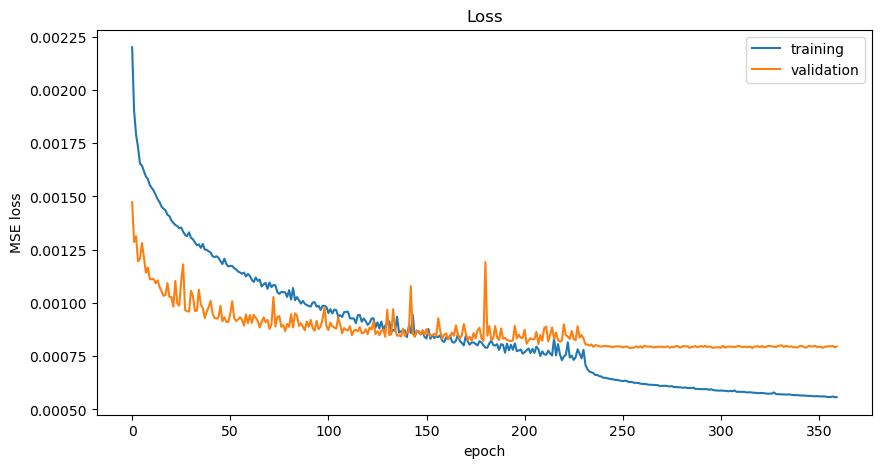

In [8]:
with open(f'../../../loss/quinn_ResDepth_v11_val_loss.pkl', 'rb') as f:
        val_loss = pickle.load(f)

with open(f'../../../loss/quinn_ResDepth_v11_train_loss.pkl', 'rb') as f:
        train_loss = pickle.load(f)


# plot loss over all epochs
f, ax = plt.subplots(figsize=(10,5))
ax.plot(train_loss, label='training')
ax.plot(val_loss, label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('MSE loss')
ax.set_title('Loss')
ax.legend()

# save figure
plt.savefig(f'../../../figs/quinn_ResDepth_v11_loss.png', dpi=300)

In [9]:
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=1, shuffle=True)

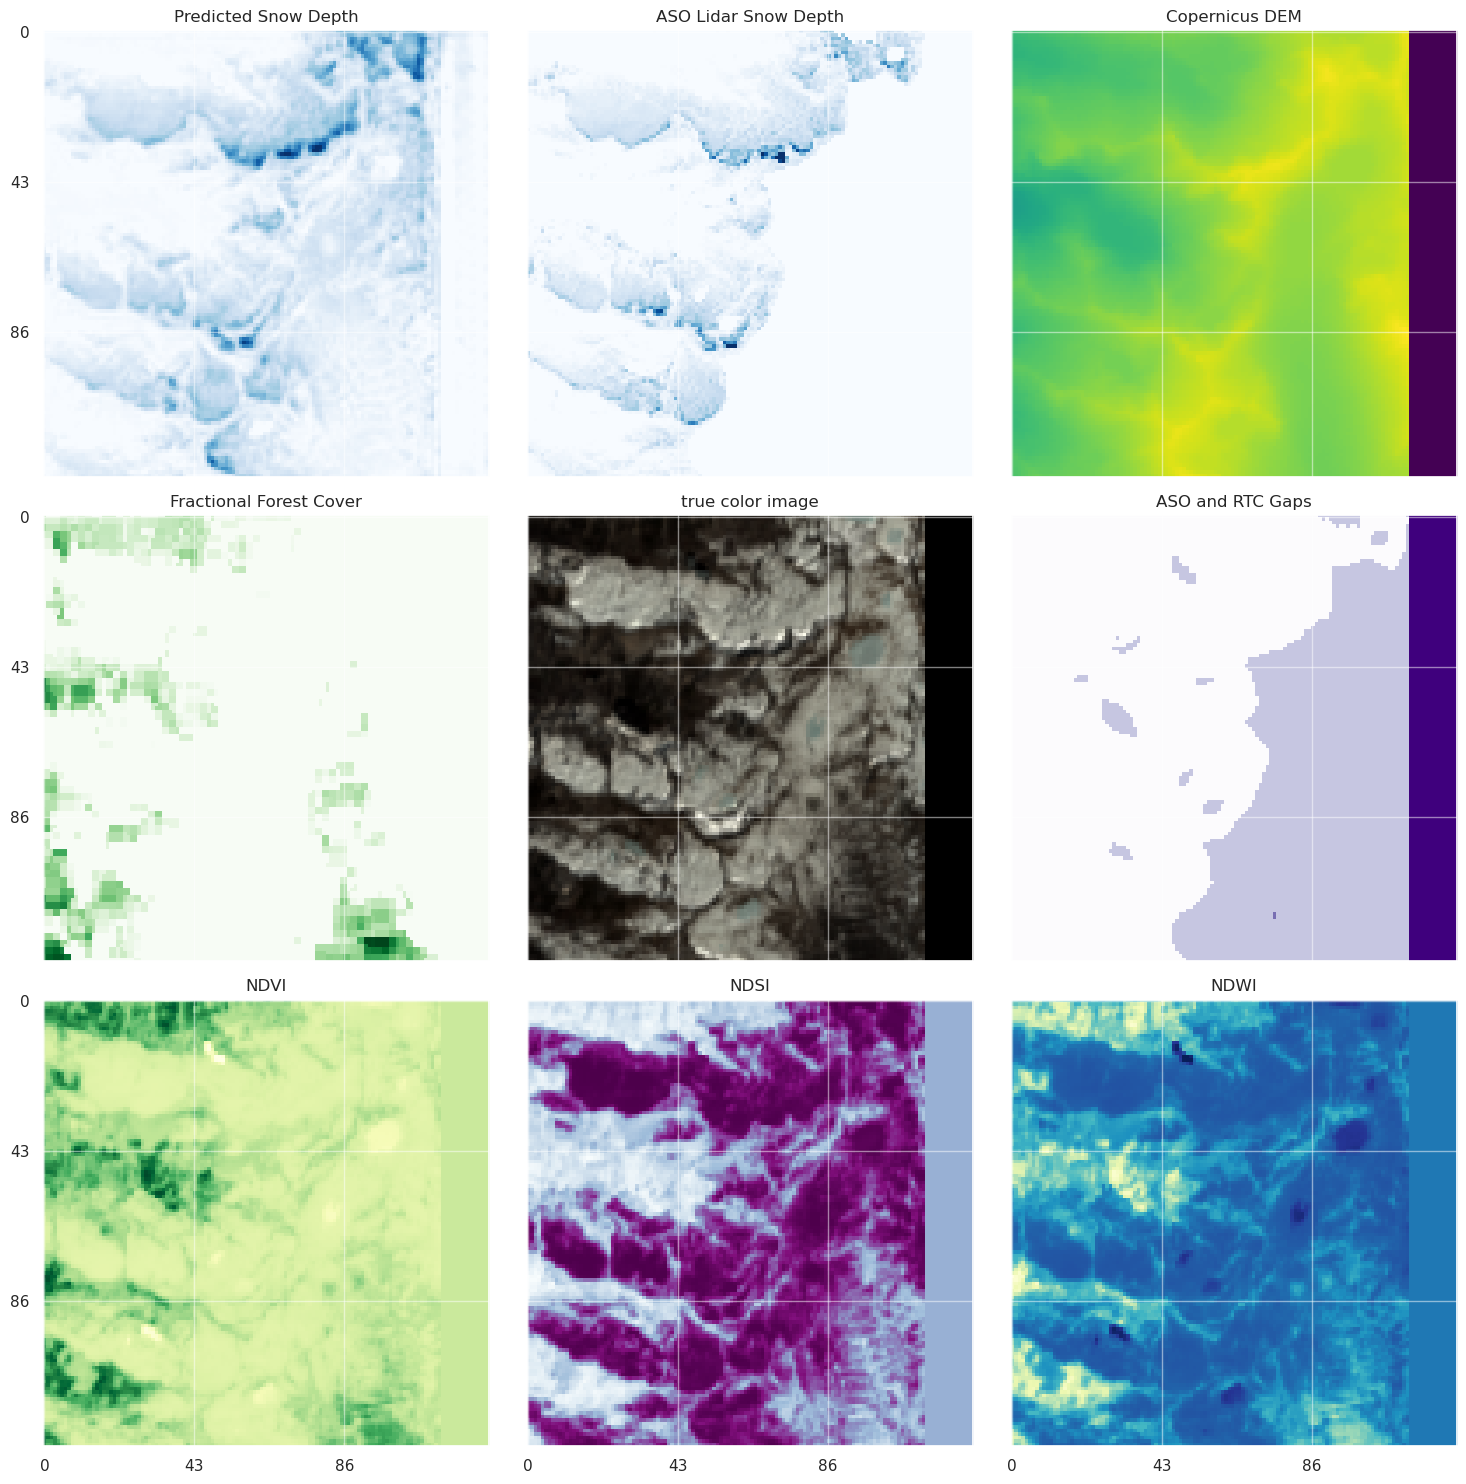

In [66]:
# visualize model predictions
sns.set_theme()
num_samples = 1

for i, data_tuple in enumerate(val_loader):
    if i < num_samples:
        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}

        with torch.no_grad():
            # Concatenate input feature channels, make prediction
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
            pred_sd = model(inputs)  # Generate predictions using the model
            pred_sd = pred_sd.to('cpu')
        
        f, ax = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)
        ax[0, 0].imshow(pred_sd.squeeze(), cmap='Blues', vmin=0, vmax=0.4, interpolation=None)
        ax[0, 0].set_title('Predicted Snow Depth')
        ax[0, 1].imshow(data_dict['aso_sd'].squeeze(), cmap='Blues', vmin=0, vmax=0.4, interpolation=None)
        ax[0, 1].set_title('ASO Lidar Snow Depth')
        ax[0, 2].imshow(data_dict['elevation'].squeeze(), cmap='viridis', interpolation='none')
        ax[0, 2].set_title('Copernicus DEM')
        ax[1, 0].imshow(data_dict['fcf'].squeeze(), cmap='Greens', interpolation='none')
        ax[1, 0].set_title('Fractional Forest Cover')
        norm_max = np.max([data_dict['green'].max(), data_dict['red'].max(), data_dict['blue'].max()]) # there are better ways to do this
        ax[1, 1].imshow(torch.cat((data_dict['red'].squeeze()[:, :, None]/norm_max, data_dict['green'].squeeze()[:, :, None]/norm_max, data_dict['blue'].squeeze()[:, :, None]/norm_max), 2).squeeze(), interpolation='none')
        ax[1, 1].set_title('true color image')
        ax[1, 2].imshow(data_dict['aso_gap_map'].squeeze() + data_dict['rtc_gap_map'].squeeze() + data_dict['s2_gap_map'].squeeze(), cmap='Purples', interpolation='none')
        ax[1, 2].set_title('ASO and RTC Gaps')
        ax[2, 0].imshow(data_dict['ndvi'].squeeze(), cmap='YlGn', interpolation='none')
        ax[2, 0].set_title('NDVI')
        ax[2, 1].imshow(data_dict['ndsi'].squeeze(), cmap='BuPu', interpolation='none')
        ax[2, 1].set_title('NDSI')
        ax[2, 2].imshow(data_dict['ndwi'].squeeze(), cmap='YlGnBu', interpolation='none')
        ax[2, 2].set_title('NDWI')
        
        # modify plot style
        for a in ax.flat:
            a.set_aspect('equal')
            a.set_xticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[1], 43))
            a.set_yticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[0], 43))
            a.grid(True, linewidth=1, alpha=0.5)
        
        f.tight_layout()
    else:
        break

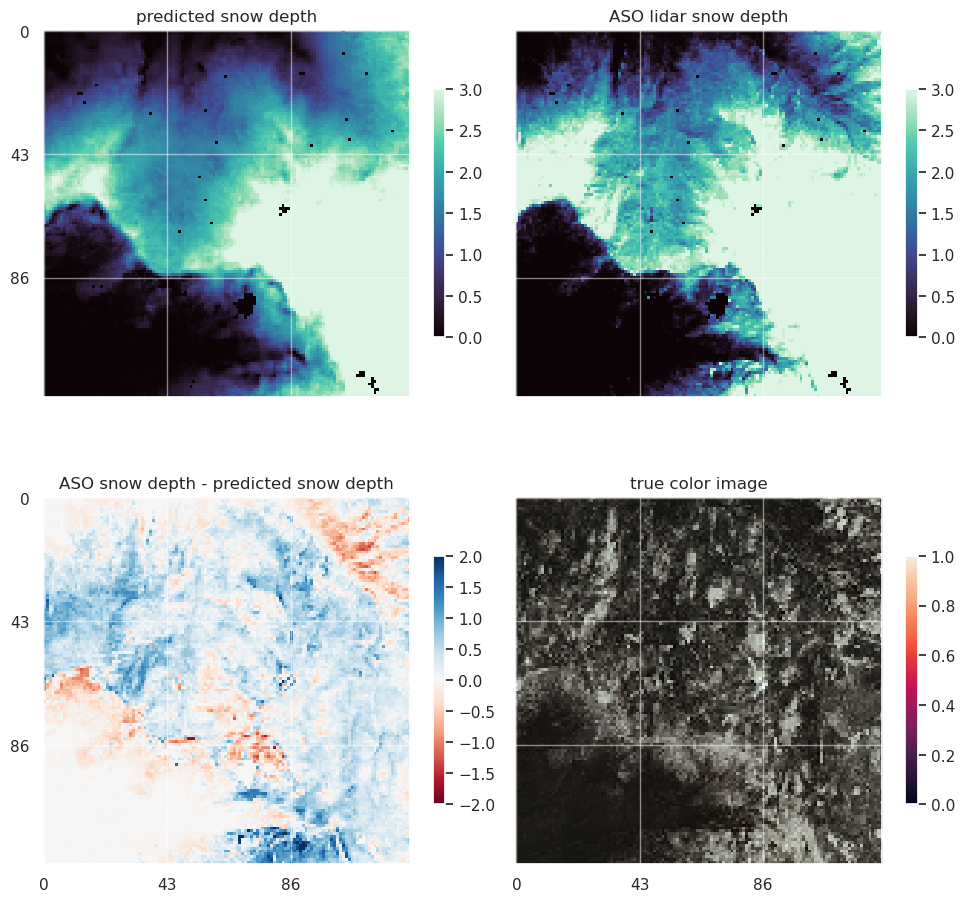

In [107]:
# visualize prediction error
sns.set_theme()
num_samples = 1
norm_dict = deep_snow.dataset.norm_dict

for i, data_tuple in enumerate(val_loader):
    if i < num_samples:
        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}

        with torch.no_grad():
            # Concatenate input feature channels, make prediction
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
            pred_sd = model(inputs)  # Generate predictions using the model
            pred_sd = pred_sd.to('cpu')

            # mask nodata areas
            pred_sd = torch.where(data_dict['aso_gap_map']+data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, pred_sd, torch.zeros_like(pred_sd))
            aso_sd = torch.where(data_dict['aso_gap_map']+data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, data_dict['aso_sd'], torch.zeros_like(pred_sd))

            # undo normalization
            pred_sd = deep_snow.dataset.undo_norm(pred_sd, deep_snow.dataset.norm_dict['aso_sd']).squeeze()
            aso_sd = deep_snow.dataset.undo_norm(aso_sd, deep_snow.dataset.norm_dict['aso_sd']).squeeze()
            
            # mask values above 0
            pred_sd = torch.where(pred_sd >= 0, pred_sd, torch.zeros_like(pred_sd))
            
            f, ax = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
            im0 = ax[0, 0].imshow(pred_sd, cmap='mako', vmin=0, vmax=3, interpolation='none') 
            ax[0, 0].set_title('predicted snow depth')
            f.colorbar(im0, shrink=0.5)
            im1 = ax[0, 1].imshow(aso_sd, cmap='mako', vmin=0, vmax=3, interpolation='none')
            ax[0, 1].set_title('ASO lidar snow depth')
            f.colorbar(im1, shrink=0.5)

            im2 = ax[1, 0].imshow(aso_sd-pred_sd, cmap='RdBu', vmin=-2, vmax=2, interpolation='none') 
            ax[1, 0].set_title('ASO snow depth - predicted snow depth')
            f.colorbar(im2, shrink=0.5)
            norm_max = np.max([data_dict['green'].max(), data_dict['red'].max(), data_dict['blue'].max()]) # there are better ways to do this
            im3 = ax[1, 1].imshow(torch.cat((data_dict['red'].squeeze()[:, :, None]/norm_max, data_dict['green'].squeeze()[:, :, None]/norm_max, data_dict['blue'].squeeze()[:, :, None]/norm_max), 2).squeeze(), interpolation='none')
            ax[1, 1].set_title('true color image')
            f.colorbar(im3, shrink=0.5)

            # modify plot style
            for a in ax.flat:
                a.set_aspect('equal')
                a.set_xticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[1], 43))
                a.set_yticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[0], 43))
                a.grid(True, linewidth=1, alpha=0.5)

            plt.tight_layout()
    else: 
        break